In [1]:
##IMPORT
from fit_all_act import PINN_multi
import torch
import h5py
import numpy as np
import pandas as pd
from utilities import xavier_init_routine, xavier_init_routine
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys

# Training parameters 

In [6]:
#####PARAMETERS#####
#plotting
PLOT = 1

#Optimizer
MAX_ITER_LBFGS = 50000
LINESEARCH = "strong_wolfe" #"strong_wolfe" or None

#ION Channel properties
E_K = torch.tensor([-96.2], dtype = torch.float64)
G_K = torch.tensor([0.1], dtype = torch.float64)

#Model
NN_DEPTH = 15
NN_BREADTH = 20

#Training
ADAM_IT = 10000
WHOLE_DATA = True
DEVICE = "cpu"

if ~WHOLE_DATA:
    N_T = 2000 #Training set size

In [7]:
#IMPORT H5PY data
filename = './experimental_data/rCell2505.nwb'

#read data
with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])
    
f = h5py.File(filename, "r")
data  = list(f['acquisition']['timeseries']['Activation']['repetitions']['repetition1']['data'])
data2 =  list(f['acquisition']['timeseries']['Activation']['repetitions']['repetition2']['data'])
data3 =  list(f['acquisition']['timeseries']['Activation']['repetitions']['repetition3']['data'])

#convert to numpy array
arr  = np.asarray(data)
arr2 = np.asarray(data2)
arr3 = np.asarray(data3)
current  =  arr[1000:5995].squeeze()
current2 =  arr2[1000:5995].squeeze()
current3 =  arr3[1000:5995].squeeze()

#normalize input
current  =  current/current.max()
current2 =   current2/current2.max()
current3 =   current3/current3.max()

#choose act voltages between -40 and +50 
v_act = np.arange(-90, 90, 10)
idx = np.where((v_act >= -40) & (v_act <= 50))
v = v_act[idx]
current =  current[:, idx].squeeze()
current2 =  current2[:, idx].squeeze()
current3 =  current3[:, idx].squeeze()

Keys: <KeysViewHDF5 ['acquisition', 'analysis', 'checksums', 'epochs', 'file_create_date', 'general', 'identifier', 'nwb_version', 'processing', 'session_description', 'session_start_time', 'stimulus']>


In [8]:
#Build layer list
layers = [2] #nb of inputs
for i in range(NN_DEPTH):  # nb of layers
    layers.append(NN_BREADTH)
layers.append(1) #output size

#import  data
PATH = './experimental_data/Kv1.2/Exp/Kv1.2_2505_rep2_Current.txt'
data = pd.read_csv(PATH, header=None, delim_whitespace=True)
#concatenate all experiments
t = np.concatenate((data[0], data[0], data[0]))
Ik =  np.concatenate((current, current2,  current3))

#stimulus
PATH_act = './experimental_data/Kv1.2/Exp/Kv1.2_2505_rep2_Stimulus.txt'
v_act = pd.read_csv(PATH_act, header=None, delim_whitespace=True).to_numpy().squeeze()
v_train = v_act

# Domain bounds
lb = np.asarray([t.min(0), v_act.min(-1)])
ub = np.asarray([t.max(0), v_act.max(-1)])

if WHOLE_DATA:
    # use all the data
    t_train = t

else:
    idx = np.arange(11)  # make sure rise is in training data
    idx = np.sort(np.concatenate((idx, np.random.choice(t.shape[0], N_T, replace=False))))
    t_train = t[idx]
    Ik = Ik.iloc[idx, :].to_numpy()

# Training

In [9]:
############ TRAINING #############

# Build model
model = PINN_multi(t_train, v_train, Ik, layers, lb, ub, max_iter_lbfgs=MAX_ITER_LBFGS, device = DEVICE)
model.apply(xavier_init_routine)  # initialize nn

# TRAIN
model.train(ADAM_IT)

It: 0, Loss: 1.278e+01
Loss: 1.075e+01
Loss: 7.471e+00
Loss: 1.055e+01
Loss: 2.474e+00
Loss: 2.394e+00
Loss: 2.099e+00
training over


# Plot results

In [20]:
#Functions
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    """

    out = []
    for i in range(len(color)):
        try:
            c = mc.cnames[color[i]]
        except:
            c = color[i]
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        out.append(colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2]))
    return out

def sig2(v):
    """computes sigmoid function for m_tau"""
    vBreak = -79.1345
    offset1 = 0.27482
    amp1 =  38.4251
    vh1 = -53.4992
    slope1 = 5.0003
    offset2 = 0.54781
    amp2 = 5.6426
    vh2 = -18.1111
    slope2 = 12.5306
    
    sigswitch = 1/(1+np.exp((v-vBreak)/3.0))
    sig2 = (sigswitch*(offset1+(amp1)/(1+np.exp((v-vh1)/-slope1)))) + ((1-sigswitch)*offset2+(amp2-offset2)/(1+np.exp((v-vh2)/slope2)))
	
    return sig2

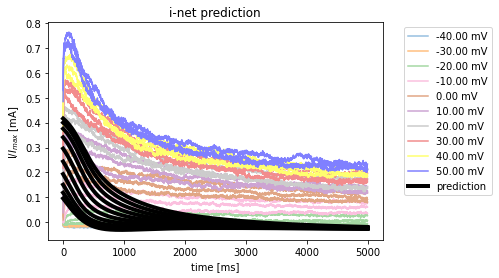

In [18]:
#color list for plotting 
t = np.arange(0, 4990, 1)
col = lighten_color(['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00', 'b'], 0.5)

#CONSTRUCT INPUT DATA for prediction
t_tens = torch.tensor(t, dtype=torch.float64, device = "cuda").unsqueeze(-1)
v_tens = torch.tensor(v_train, dtype=torch.float64, device = "cuda").unsqueeze(-1)
_, _, Xin = model.construct_input(t_tens, v_tens)

#predictions
u_pred = model.predict(Xin)
u_pred = ((u_pred + 1)*(model.I.max().cpu().detach().numpy() - model.I.min().cpu().detach().numpy())/2+model.I.min().cpu().detach().numpy())
vol = np.arange(-40, 60, 10)

#PLOT
plt.title("i-net prediction")
for i in range(current.shape[1]):
    plt.plot(t, current[:4990, i], color=col[i])
    plt.plot(t, current2[:4990, i],  color=col[i])
    plt.plot(t, current3[:4990, i], color=col[i], label = '%.2f mV'%vol[i])


plt.xlabel("time [ms]")
plt.ylabel(r"I/$I_{max}$ [mA]")
plt.plot(t, np.squeeze(u_pred)[:, :-1], 'k', linewidth = 4.0)
plt.plot(t, np.squeeze(u_pred)[:, -1], 'k', label = "prediction", linewidth = 4.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("plots/whole_inet.svg")

In [21]:
#Theoretical parameters
m_inf_true =  1/(1+np.exp((v_act + 8.1607)/-16.2041))
m_tau_true = sig2(v_act)
h_inf_true = (1-0.6669) +( 0.6669 / (1 + np.exp((v_act + 13.2501)/13.896)))
h_tau_true = 99.0499 +( 421.1463 / (1 + np.exp((v_act + 10.7858)/13.1357)))

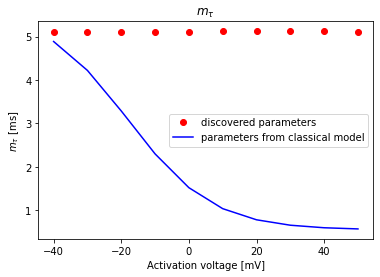

In [24]:
plt.title(r"$m_\tau$")
m_tau_d = (model.m_tau*5).cpu().detach()
plt.plot(v_act,m_tau_d, 'ro', label = "discovered parameters")
plt.plot(v, m_tau_true, 'b', label = "parameters from classical model")
plt.legend()
plt.xlabel("Activation voltage [mV]")
plt.ylabel(r"$m_\tau$ [ms]")
plt.savefig("plots/mtau.svg")

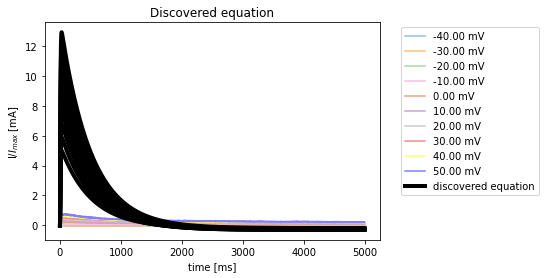

In [26]:
from scipy.integrate import odeint

#Ik = Ik.to_numpy()
m_reg = odeint(func, np.zeros(10), t, args = (model.m_inf.cpu().detach().numpy(), model.m_tau.cpu().detach().numpy()*5))
h_reg = odeint(func, np.ones(10), t, args = (model.h_inf.cpu().detach().numpy(), model.h_tau.cpu().detach().numpy()*500))
I_reg =  0.1*m_reg*m_reg*h_reg*(v_act - (-96.2))


plt.title("Discovered equation")

for i in range(current.shape[1]):
    plt.plot(t, current[:4990, i], color=col[i])
    plt.plot(t, current2[:4990, i],  color=col[i])
    plt.plot(t, current3[:4990, i], color=col[i], label = '%.2f mV'%vol[i])
    
    
plt.plot(t, I_reg[:4990, :-1], 'k', linewidth = 4.0)
plt.plot(t, I_reg[:4990, -1], 'k', label = "discovered equation", linewidth = 4.0)

plt.xlabel("time [ms]")
plt.ylabel(r"I/$I_{max}$ [mA]")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("plots/whole_eq.svg")

# MSEs

In [27]:
a = np.concatenate((u_pred[:4990], u_pred[:4990], u_pred[:4990])).squeeze()
b = np.concatenate((current[:4990],  current[:4990], current[:4990])).squeeze()

In [28]:
from torch import nn 
loss = nn.MSELoss()
i_pred = np.squeeze(u_pred)
netMSE = loss(torch.Tensor(a), torch.Tensor(b)) #loss(torch.Tensor(np.squeeze(i_pred)), torch.Tensor(Ik.to_numpy))
print('%.10f' %netMSE)

0.0348287299


In [29]:
eqMSE =loss(torch.tensor(np.concatenate((I_reg, I_reg, I_reg)).squeeze(), dtype = torch.float64), torch.tensor(np.concatenate((current[:4990],  current[:4990], current[:4990])), dtype = torch.float64))
print('%.10f' %eqMSE)

4.0442078072
